<a href="https://colab.research.google.com/github/faheem-khaskheli/tensorflow_basics/blob/main/Grad_Class_Activation_Map_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import plot_model

In [ ]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train/255
X_test = X_test/255
X_train = X_train.astype('float')
X_test = X_test.astype('float')

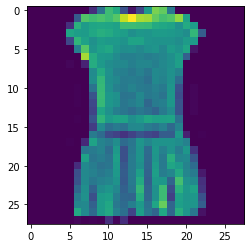

In [ ]:
def show_img(img):
  img = np.array(img, dtype='float')
  img = img.reshape((28, 28))
  plt.imshow(img)

show_img(X_train[3])

In [ ]:
model = Sequential()
model.add(Conv2D(16, input_shape=(28, 28, 1), kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))

model.summary()
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 3, 3, 128)        

In [ ]:
model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.1, shuffle=True)

Epoch 1/5
1688/1688 [==============================] - 60s 35ms/step - loss: 0.8571 - accuracy: 0.6818 - val_loss: 0.4085 - val_accuracy: 0.8515
Epoch 2/5
1688/1688 [==============================] - 52s 31ms/step - loss: 0.3980 - accuracy: 0.8553 - val_loss: 0.3674 - val_accuracy: 0.8632
Epoch 3/5
1688/1688 [==============================] - 52s 31ms/step - loss: 0.3300 - accuracy: 0.8774 - val_loss: 0.2988 - val_accuracy: 0.8872
Epoch 4/5
1688/1688 [==============================] - 52s 31ms/step - loss: 0.2795 - accuracy: 0.8980 - val_loss: 0.2844 - val_accuracy: 0.8970
Epoch 5/5
1688/1688 [==============================] - 53s 31ms/step - loss: 0.2493 - accuracy: 0.9085 - val_loss: 0.2831 - val_accuracy: 0.8963


In [ ]:
print(model.layers[-3].name)
print(model.layers[-1].name)

conv2d_11
dense_1


In [ ]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

(128, 10)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8_input (InputLayer)  [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)          0     

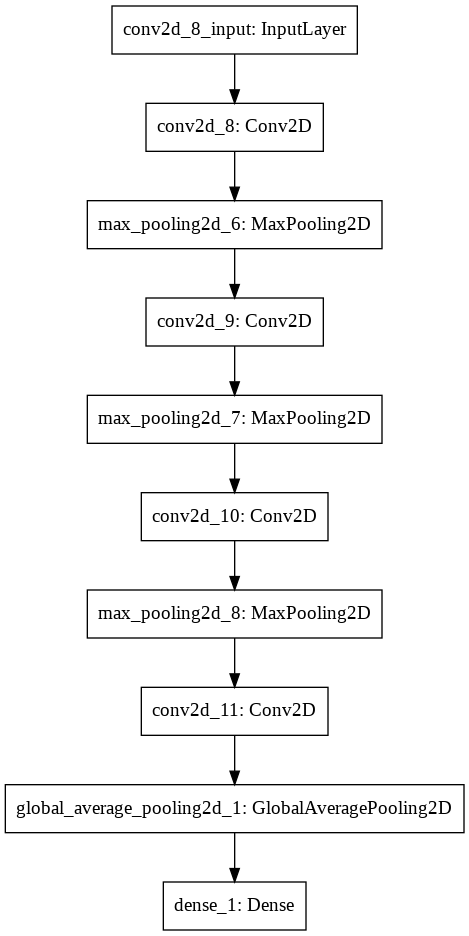

In [ ]:
import scipy as sp

(10000, 3, 3, 128)

In [ ]:
def get_cam(processed_image, predicted_label, layer_name):
  model_grad = Model(inputs=model.input,
                     outputs=(model.get_layer(layer_name).output,
                              model.output))

  with tf.GradientTape() as tape:
    conv_output_values, predictions = model_grad(processed_image)
    loss = predictions[:, predicted_label]

    # compute gradient
    grads_values = tape.gradient(loss, conv_output_values)

    # Mean of gradients per feature map
    grad_values = K.mean(grads_values, axis=(0, 1, 2))

    conv_output_values = np.squeeze(conv_output_values.numpy())
    grad_values = grad_values.numpy()

  for i in range(512): # we have 512 fetures in our last conv layer
    conv_output_values[:,:,i] *= grads_values[i]

  # heatmap
  heatmap = np.mean(conv_output_values, axis=-1)

  # remove negative values
  heatmap = np.maximum(heatmap, 0)
  
  # Normalize
  heatmap /= heatmap.max()

  def model_grad, counv_output_values, grads_values, loss
  return heatma

#  cam_output = np.dot(class_activation_features, class_activation_weights)
#  
#  print("Prediction Class = "+str(prediction)+ ', Probability = '+ str(results[image_index][prediction]))
#
#  plt.imshow(np.squeeze(X_test[image_index], -1), alpha=0.5)
#  if results[image_index][prediction] > 0.95:
#    cmap_str = 'Greens'
#  else:
#    cmap_str = 'Reds'
#  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)
#  plt.show()

Prediction Class = 2, Probability = 0.999858


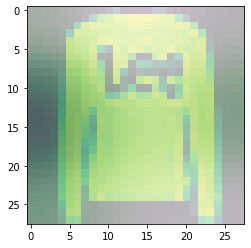

Prediction Class = 2, Probability = 0.99887556


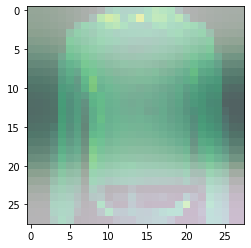

Prediction Class = 2, Probability = 0.9938199


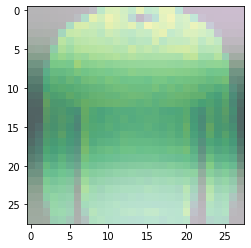

Prediction Class = 2, Probability = 0.9628618


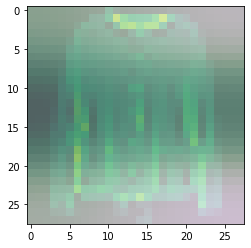

Prediction Class = 2, Probability = 0.93553644


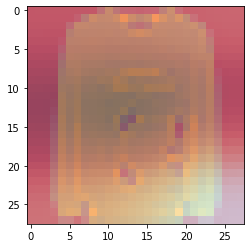

Prediction Class = 2, Probability = 0.9298271


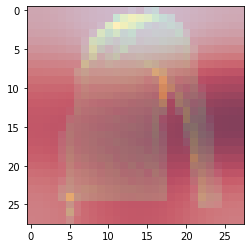

Prediction Class = 2, Probability = 0.9923234


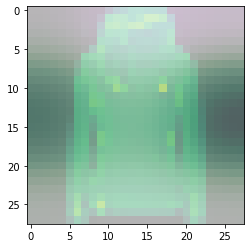

Prediction Class = 2, Probability = 0.9948886


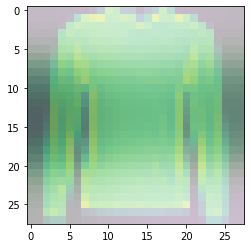

Prediction Class = 2, Probability = 0.99333787


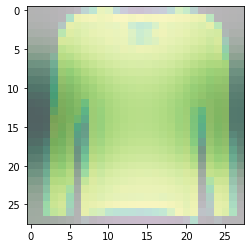

Prediction Class = 2, Probability = 0.88526976


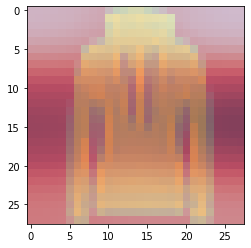

Prediction Class = 2, Probability = 0.99963784


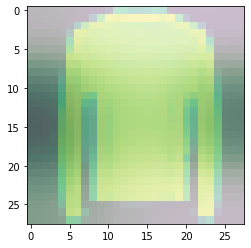

Prediction Class = 2, Probability = 0.9999585


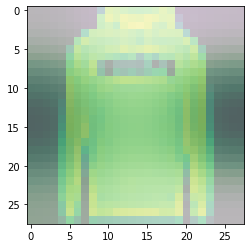

Prediction Class = 2, Probability = 0.7952477


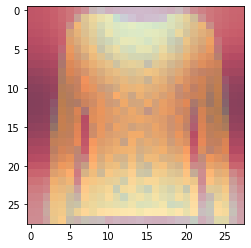

Prediction Class = 2, Probability = 0.860074


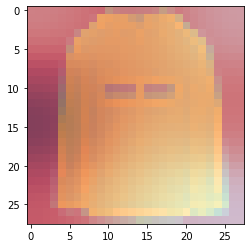

Prediction Class = 2, Probability = 0.9989385


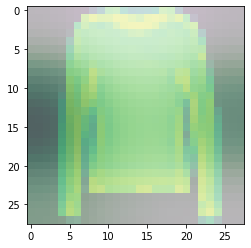

In [ ]:
desired_class = 2
for i in range(0, 100):
  if np.argmax(results[i]) == desired_class:
    show_cam(i)